<span style="font-size:18pt; font-weight:bold;">Pytorch</span>

In [13]:
import torch, numpy as np

In [14]:
a=np.arange(6, dtype=np.float32).reshape(2,3)

In [15]:
t = torch.from_numpy(a)

In [16]:
t

tensor([[0., 1., 2.],
        [3., 4., 5.]])

In [17]:
u=t.numpy()

In [18]:
u

array([[0., 1., 2.],
       [3., 4., 5.]], dtype=float32)

In [ ]:
<span style="font-size:16pt; font-weight:bold;">Autograd</span>

In [33]:
w=torch.tensor(4.5, requires_grad=True)
f = (w - 2)**2
f.backward()
float(w), float(f), float(w.grad)

(4.5, 6.25, 5.0)

In [34]:
with torch.no_grad():
    w -= 0.3 * w.grad
    w.grad.zero_()
w

tensor(3., requires_grad=True)

In [35]:
w=torch.tensor([1.0,-2.0,3.0],requires_grad=True)
f=(w**2).sum()
f.backward()
w.grad

tensor([ 2., -4.,  6.])

In [36]:
w.grad

tensor([ 2., -4.,  6.])

In [38]:
w=torch.tensor([1.0,-2.0,3.0],requires_grad=True)
f=(w**2).sum()
f.backward(retain_graph=True)
w.grad
f.backward()
w.grad

tensor([ 4., -8., 12.])

In [43]:
A=torch.randn(2,3)
y=torch.randn(2)
w=torch.randn(3, requires_grad=True)

f=torch.sum((A@w-y)**2)
f.backward()
print("Autograd gradient:", w.grad)

Autograd gradient: tensor([-0.3485, -0.2128,  2.6044])


In [44]:
with torch.no_grad():
    manual_grad= 2*A.t()@(A@w-y)
print("Manual gradient:",manual_grad)

Manual gradient: tensor([-0.3485, -0.2128,  2.6044])


<span style="font-size:12pt; font-weight:bold;">Write a tiny training loop that fits y≈wx+b by gradient descent; log the loss and verify it decreases</span>

In [55]:
import torch

torch.manual_seed(40)
x=torch.linspace(0,1,20)
w_true=2.0
b_true=-1.0
y = w_true * x + b_true + 0.1*torch.randn_like(x)
# ---parameters to learn---
w=torch.randn(1,requires_grad=True)
b=torch.randn(1,requires_grad=True)
lr=0.1 # learning rate

# training loop
for step in range(30):
    # forward pass: compute predicted y
    y_pred=w*x+b
    # loss=mean squared error
    loss=torch.mean((y_pred-y)**2)

    #backward pass:compute gradients
    loss.backward()

    # gradient descent update
    with torch.no_grad():
        w -= lr * w.grad
        b -= lr * b.grad

    # reset gradients
    w.grad.zero_()
    b.grad.zero_()

    print(f"step {step:02d}  loss = {loss.item():.4f}")

print("\nLearned w, b:", w.item(), b.item())
    

step 00  loss = 1.0189
step 01  loss = 0.7025
step 02  loss = 0.5225
step 03  loss = 0.4187
step 04  loss = 0.3572
step 05  loss = 0.3196
step 06  loss = 0.2952
step 07  loss = 0.2783
step 08  loss = 0.2657
step 09  loss = 0.2556
step 10  loss = 0.2470
step 11  loss = 0.2392
step 12  loss = 0.2321
step 13  loss = 0.2253
step 14  loss = 0.2189
step 15  loss = 0.2127
step 16  loss = 0.2067
step 17  loss = 0.2009
step 18  loss = 0.1953
step 19  loss = 0.1899
step 20  loss = 0.1846
step 21  loss = 0.1795
step 22  loss = 0.1745
step 23  loss = 0.1696
step 24  loss = 0.1649
step 25  loss = 0.1604
step 26  loss = 0.1559
step 27  loss = 0.1516
step 28  loss = 0.1475
step 29  loss = 0.1434

Learned w, b: 0.7760543823242188 -0.33904725313186646


Implement a manual forward for a 2‑layer MLP and verify output shapes on random data.

manual forward pass for a 2-layer MLP

In [57]:
import torch
torch.manual_seed(0)

# ---dimensions
batch_size=5
input_dim=3
hidden_dim=4
output_dim=2

# ---random input data
x=torch.randn(batch_size,input_dim) # (5,4)

# parameters for 2 layer MLP
w1=torch.randn(input_dim,hidden_dim) # (3,4)
b1=torch.randn(hidden_dim)

w2=torch.randn(hidden_dim,output_dim) #(4,2)
b2=torch.randn(output_dim)

# Manual forward pass
#layer 1:linear
h_pre=x@w1+b1 # shape (5,4)

#Nonlinearlity - ReLU here
h=torch.clamp(h_pre,min=0.0) # still (5,4)

#layer 2: linear
y_pred = h@w2 +b2


Verify shapes

In [59]:
print("X shape:      ", x.shape)       # (5, 3)
print("h_pre shape:  ", h_pre.shape)   # (5, 4)
print("h shape:      ", h.shape)       # (5, 4)
print("y_pred shape: ", y_pred.shape)  # (5, 2)

X shape:       torch.Size([5, 3])
h_pre shape:   torch.Size([5, 4])
h shape:       torch.Size([5, 4])
y_pred shape:  torch.Size([5, 2])


Recreate the XOR decision regions with different activations (tanh vs ReLU)

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(0)

# XOR data
X = torch.tensor([[0., 0.],
                  [0., 1.],
                  [1., 0.],
                  [1., 1.]])
y = torch.tensor([0., 1., 1., 0.]).unsqueeze(1)  # shape (4, 1)


class TinyMLP(nn.Module):
    def __init__(self, hidden_dim=4, activation="tanh"):
        super().__init__()
        self.fc1 = nn.Linear(2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

        if activation == "tanh":
            self.act = nn.Tanh()
        elif activation == "relu":
            self.act = nn.ReLU()
        else:
            raise ValueError("activation must be 'tanh' or 'relu'")

    def forward(self, x):
        h = self.act(self.fc1(x))
        out = torch.sigmoid(self.fc2(h))  # binary output in (0,1)
        return out

    def train_xor(model, X, y, lr=0.1, steps=5000):
        criterion = nn.BCELoss()
        optimizer = optim.SGD(model.parameters(), lr=lr)
    
        for step in range(steps):
            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
    
            if step % 1000 == 0:
                print(f"{model.__class__.__name__} ({model.act.__class__.__name__}) "
                      f"step {step:4d}  loss={loss.item():.4f}")

In [67]:
mlp_tanh = TinyMLP(hidden_dim=4, activation="tanh")
mlp_relu = TinyMLP(hidden_dim=4, activation="relu")

mlp_tanh.train_xor(X, y)
mlp_relu.train_xor(X, y)

TinyMLP (Tanh) step    0  loss=0.7407
TinyMLP (Tanh) step 1000  loss=0.0413
TinyMLP (Tanh) step 2000  loss=0.0111
TinyMLP (Tanh) step 3000  loss=0.0061
TinyMLP (Tanh) step 4000  loss=0.0041
TinyMLP (ReLU) step    0  loss=0.7589
TinyMLP (ReLU) step 1000  loss=0.6932
TinyMLP (ReLU) step 2000  loss=0.6931
TinyMLP (ReLU) step 3000  loss=0.6931
TinyMLP (ReLU) step 4000  loss=0.6931


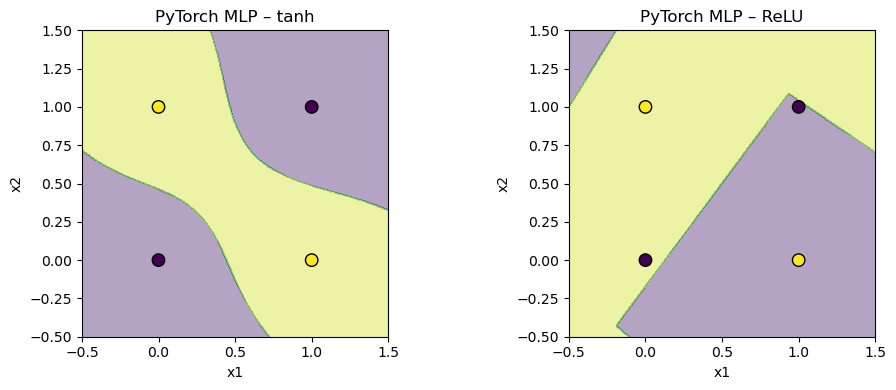

In [68]:
def plot_decision_regions_torch(model, ax, title):
    # make grid in input space
    xx, yy = np.meshgrid(
        np.linspace(-0.5, 1.5, 300),
        np.linspace(-0.5, 1.5, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_t = torch.tensor(grid, dtype=torch.float32)

    with torch.no_grad():
        probs = model(grid_t).numpy().reshape(xx.shape)
        Z = (probs > 0.5).astype(int)

    # background
    ax.contourf(xx, yy, Z, alpha=0.4)
    # training points
    ax.scatter(X[:, 0].numpy(), X[:, 1].numpy(),
               c=y.squeeze().numpy(), s=80, edgecolor="k")
    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_aspect("equal")


fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_decision_regions_torch(mlp_tanh, axes[0], "PyTorch MLP – tanh")
plot_decision_regions_torch(mlp_relu, axes[1], "PyTorch MLP – ReLU")

plt.tight_layout()
plt.show()
